## ML tests on Conical debris bed COCOMO simulations
#### ++++++
#### Author: Jasmin Joshi-Thompson
#### jasminjthompson@gmail.com
#### ++++++

## Workflow
1. Import sim results consiting of 
    - time  detected  SIM_ID      Psys  Ffuel  Porosity Dparticle  Alpha  Rflat    Tbed    Decay  Fstruct  
2. Normlaise and pred (1,0) quench or melt
3. Import quench front matrix
4. use NN to predict matrix from inputs

In [88]:
# Standard library imports
import os
import sys
import time
import io
from datetime import datetime
import math

# Third-party library imports
import numpy as np
import ast
import pandas as pd

import json
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from adjustText import adjust_text
from fpdf import FPDF
from scipy import signal
from scipy.signal import argrelextrema, find_peaks, savgol_filter
import seaborn as sns
import joblib
import keras
import tensorflow as tf
import keras_tuner
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

#from tensorflow_addons.metrics import RSquare
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import RepeatedKFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, recall_score, f1_score, precision_score, roc_curve
#from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.utils import resample
import matplotlib.colors as colors
from matplotlib import gridspec
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score


# Tkinter imports
import tkinter as tk
from tkinter import filedialog, simpledialog
from tkinter.filedialog import askdirectory

# Placeholder for functions and other custom imports
# import h5py
# from keras.models import load_model
# import sns
# import simpledialog


      time  detected                     SIM_ID      Psys  Ffuel  Porosity  \
0  5730.63    melted        batchlocal1_run0000  168500.0  0.865    0.3525   
1  1330.06  quenched        batchlocal1_run0001  402500.0  0.635    0.4275   
2  1330.06  quenched  batchlocal1_nostopcondrun  472700.0  0.995    0.3325   
3  3802.32  quenched        batchlocal1_run0002  285500.0  0.835    0.4825   
4  1951.35  quenched        batchlocal1_run0003  293300.0  0.895    0.3475   

   Dparticle  Alpha  Rflat    Tbed    Decay  Fstruct  
0    0.00184   17.1   1.18  1219.0  0.00825   1.0025  
1    0.00456   24.9   0.78  1453.0  0.00405   1.4575  
2    0.00240   38.7   0.82   725.0  0.00671   1.0725  
3    0.00328   30.9   1.90  1687.0  0.00489   1.4225  
4    0.00264   35.7   1.42   829.0  0.00545   1.5275  


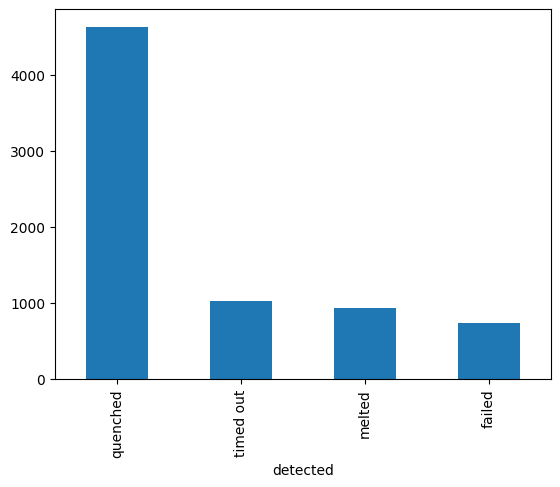

In [89]:
# open data
df = pd.read_csv(r"D:\Users\ikejjosh\Documents\COCOMO\debris_cone\sim_results.csv")
print(df.head())
#make histogram of detected columns for categorical data
df['detected'].value_counts().plot(kind='bar')
#replace 
og_df = df.copy()

In [90]:
# print the totoal in each cataegory
print(df['detected'].value_counts())
# get the percentage of failed + timeout / total
print((df['detected'].value_counts()[1] + df['detected'].value_counts()[3]) / df['detected'].count())


detected
quenched     4633
timed out    1028
melted        939
failed        735
Name: count, dtype: int64
0.2403544648943422


C:\Users\ikejjosh\AppData\Local\Temp\ipykernel_30888\1858198816.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print((df['detected'].value_counts()[1] + df['detected'].value_counts()[3]) / df['detected'].count())
C:\Users\ikejjosh\AppData\Local\Temp\ipykernel_30888\1858198816.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print((df['detected'].value_counts()[1] + df['detected'].value_counts()[3]) / df['detected'].count())


In [91]:
#look for different types in detected column
print(df['detected'].value_counts())
# search for nan values in detected
print(df['detected'].isnull().sum())


detected
quenched     4633
timed out    1028
melted        939
failed        735
Name: count, dtype: int64
41


In [92]:
# drop all rows that timed out or failed

df = df[df.detected != 'failed']

df = df[df.detected != 'timed out']

### Decision weather timed out scenario is a melting scenario
- Timed out is when the simulation hits 7200 seconds without quenching. This is a terminus for the simulation
- This could skew the prediction results as timing out is not a melting contidion, making the result non-continuious
- timed out could be added as a catagorical predictor - which is then passed on as a regression model for predicting the maximum quenching time

In [93]:
#convert catagorical data to numerical
df['detected'] = df['detected'].map({'quenched': 1, 'melted': 0})
df = df.drop(columns=['SIM_ID', 'time'])
df
#search for nan values
df.isnull().sum()
# drop all rows with nan values
df = df.dropna()
df.isnull().sum()


detected     0
Psys         0
Ffuel        0
Porosity     0
Dparticle    0
Alpha        0
Rflat        0
Tbed         0
Decay        0
Fstruct      0
dtype: int64

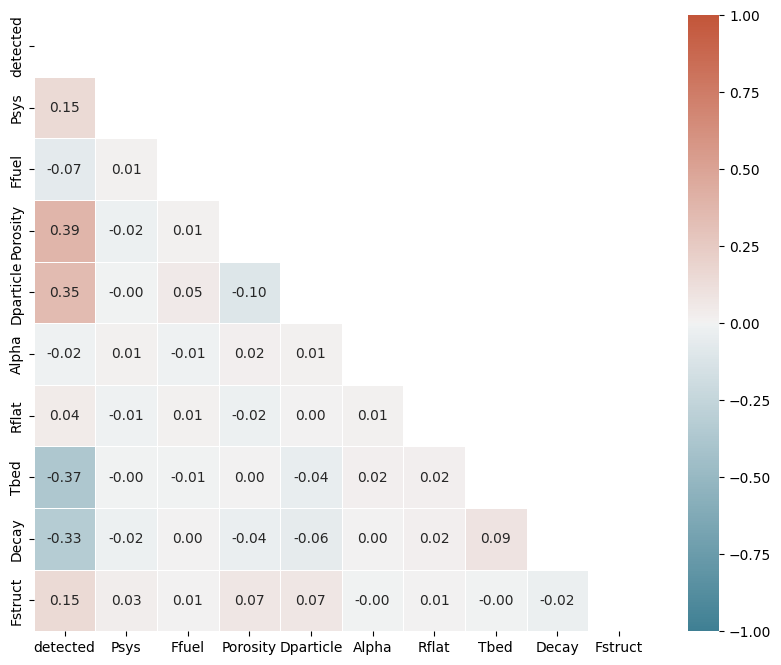

In [94]:
corr = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", ax=ax)

plt.show()


In [95]:
"""#perfrom PCA 
X = df.drop(columns=['detected'])
y = df['detected']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
# show which features are most important
print(pca.explained_variance_ratio_)
print(pca.components_)
# plot as scatter bar chart of most important features
plt.figure(figsize=(10, 5))
plt.bar(X.columns, pca.components_[0])
plt.xticks(rotation=90)
plt.show()"""

"#perfrom PCA \nX = df.drop(columns=['detected'])\ny = df['detected']\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\npca = PCA(n_components=5)\nX_pca = pca.fit_transform(X_scaled)\nX_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])\n# show which features are most important\nprint(pca.explained_variance_ratio_)\nprint(pca.components_)\n# plot as scatter bar chart of most important features\nplt.figure(figsize=(10, 5))\nplt.bar(X.columns, pca.components_[0])\nplt.xticks(rotation=90)\nplt.show()"

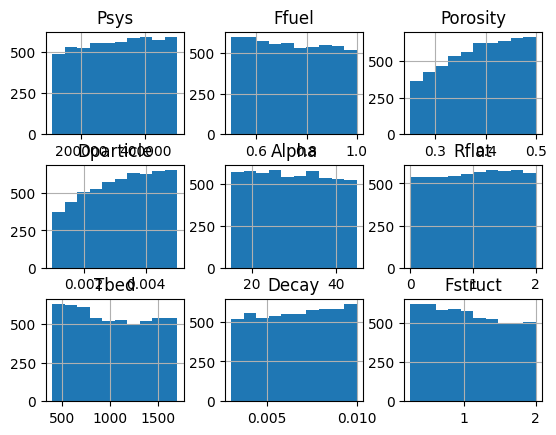

<Axes: >

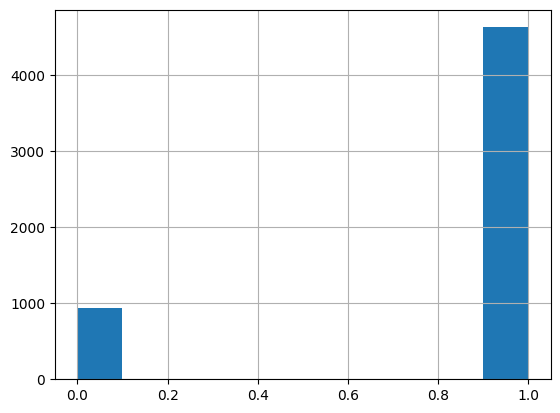

In [96]:
# Define features and labels
X = df.drop(columns='detected')
y = df['detected']
# plot distribution of each variable in X
X.hist()
plt.show()
# plot y distribution
y.hist()



In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# save data to csv
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Standardize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
# save scalaer
joblib.dump(scaler, 'MinMax_scaler_X_Classification.pkl')
X_test = scaler.transform(X_test)

# Function to evaluate and store model performance
def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    # save the fitted model
    joblib.dump(model, f'{model_name}.pkl')
    y_pred = model.predict(X_test)
    scores = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred)
    }
    return scores

# List to store performance results
results = []

# Logistic Regression
log_reg = LogisticRegression()
results.append(evaluate_model(log_reg, 'Logistic Regression'))

# Random Forest
rf = RandomForestClassifier()
results.append(evaluate_model(rf, 'Random Forest'))

# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
results.append(evaluate_model(best_rf, 'Tuned Random Forest'))

# Support Vector Machine
svc = SVC(probability=True)
results.append(evaluate_model(svc, 'Support Vector Machine'))

# K-Nearest Neighbors
knn = KNeighborsClassifier()
results.append(evaluate_model(knn, 'K-Nearest Neighbors'))

# Gradient Boosting
gb = GradientBoostingClassifier()
results.append(evaluate_model(gb, 'Gradient Boosting'))

# AdaBoost
ada = AdaBoostClassifier()
results.append(evaluate_model(ada, 'AdaBoost'))

# Decision Tree
dt = DecisionTreeClassifier()
results.append(evaluate_model(dt, 'Decision Tree'))

# Gaussian Naive Bayes
gnb = GaussianNB()
results.append(evaluate_model(gnb, 'Gaussian Naive Bayes'))

# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
results.append(evaluate_model(lda, 'Linear Discriminant Analysis'))

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
results.append(evaluate_model(xgb, 'XGBoost'))

# LightGBM
lgbm = lgb.LGBMClassifier()
results.append(evaluate_model(lgbm, 'LightGBM'))

# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', log_reg), ('rf', best_rf), ('svc', svc), ('knn', knn),
    ('gb', gb), ('ada', ada), ('dt', dt), ('gnb', gnb), ('lda', lda),
    ('xgb', xgb), ('lgbm', lgbm)
], voting='soft')
# save the model





results.append(evaluate_model(voting_clf, 'Voting Classifier'))

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

c:\Users\ikejjosh\ML_venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ikejjosh\ML_venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3691, number of negative: 765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 4456, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.828321 -> initscore=1.573777
[LightGBM] [Info] Start training from score 1.573777


c:\Users\ikejjosh\ML_venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ikejjosh\ML_venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3691, number of negative: 765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 4456, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.828321 -> initscore=1.573777
[LightGBM] [Info] Start training from score 1.573777
                           Model  Accuracy  Precision    Recall  F1 Score  \
0            Logistic Regression  0.981149   0.988310  0.989362  0.988836   
1                  Random Forest  0.977558   0.975078  0.998936  0.986863   
2            Tuned Random Forest  0.973070   0.971014  0.997872  0.984260   
3         Support Vector Machine  0.991921   0.995740  0.994681  0.995210   
4            K-Nearest Neighbors  0.960503   0.971579  0.981915  0.976720   
5              Gradient Boosting  0.981149   0.9811

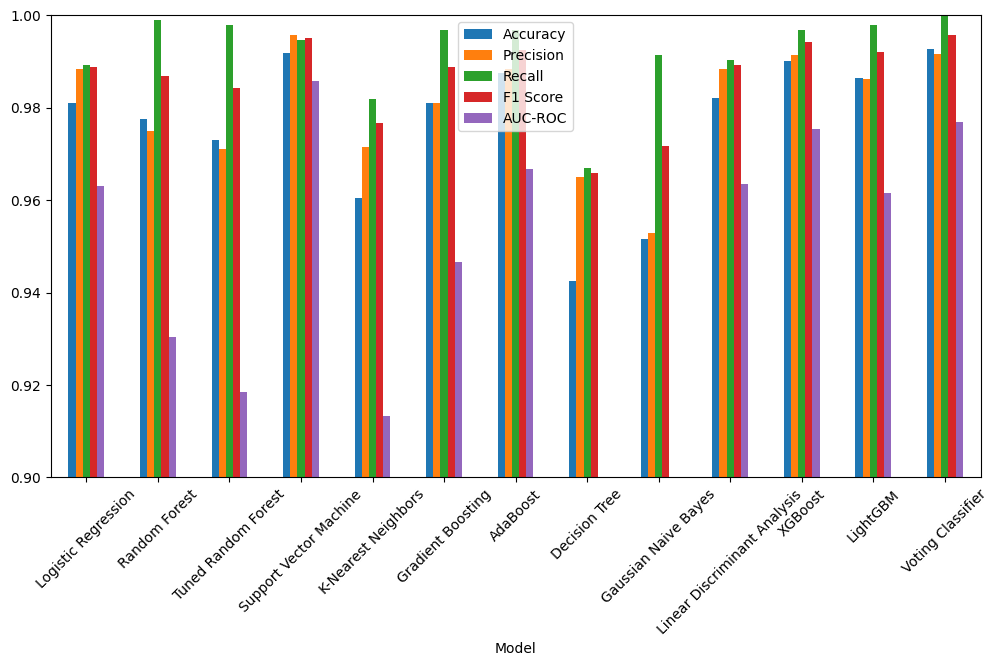

In [98]:
# make a bar chart of the results
results_df.plot(x='Model', y=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'], kind='bar', figsize=(12, 6))
plt.xticks(rotation=45)
# make y axus go from 0.9 to 1
plt.ylim(0.9, 1)
plt.show()


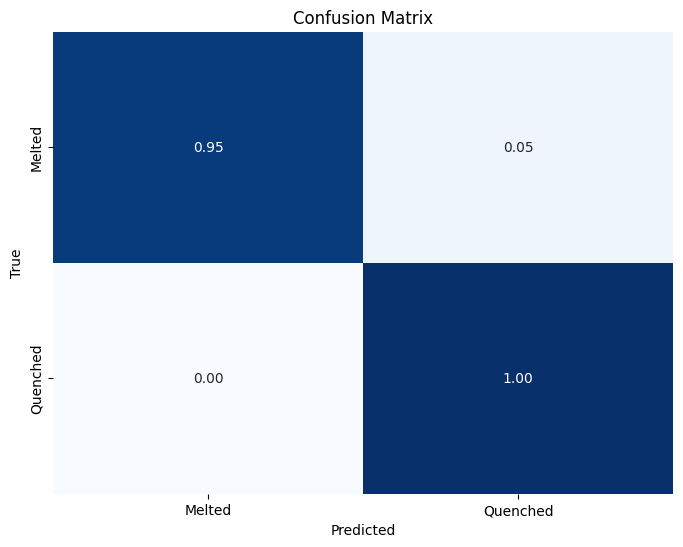

In [99]:
# plot confusting matrix for best model

# confustion matrix of voting classifier
y_pred = voting_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Melted', 'Quenched'], yticklabels=['Melted', 'Quenched'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [100]:
# how long does it take to make one prediction
start_time = time.time()
y_pred = voting_clf.predict(X_test)
end_time = time.time()
print("Time taken to make one prediction: ", end_time - start_time)
len(y_pred)

Time taken to make one prediction:  0.08483648300170898


1114

In [101]:


# which silumations where falsy predicted
false_predictions = X_test[y_pred != y_test]
# save false predictions to csv
print(false_predictions)
len(false_predictions)
# reverse transform the data
false_predictions = scaler.inverse_transform(false_predictions)
#fint the index of the false predictions
print(false_predictions)
# search for these falues in og_df
false_predictions = pd.DataFrame(false_predictions, columns=X.columns)
# give them the same column names as og_df:  Psys  Ffuel  Porosity  Dparticle  Alpha  Rflat    Tbed    Decay  Fstruct
false_predictions.columns = ['Psys', 'Ffuel', 'Porosity', 'Dparticle', 'Alpha', 'Rflat', 'Tbed', 'Decay', 'Fstruct']
false_predictions


[[0.08058058 0.14064064 0.67317317 0.25675676 0.18468468 0.66716717
  0.90940941 0.66516517 0.48104117]
 [0.15815816 0.93193193 0.45745746 0.87187187 0.66566567 0.38238238
  0.99399399 0.46146146 0.34438744]
 [0.23923924 0.44344344 0.15115115 0.94894895 0.30830831 0.00700701
  0.96396396 0.25925926 0.16919034]
 [0.17117117 0.08108108 0.11711712 0.87187187 0.13913914 0.12012012
  0.93893894 0.28528529 0.26629959]
 [0.46446446 0.75975976 0.36636637 0.53753754 0.44544545 0.08508509
  0.67967968 0.44544545 0.08910024]
 [0.02902903 0.08708709 0.77877878 0.11111111 0.82482482 0.30930931
  0.27227227 0.88588589 0.11613065]
 [0.54204204 0.58608609 0.93043043 0.1016016  0.2977978  0.14964965
  0.93843844 0.57807808 0.65023151]
 [0.01301301 0.8008008  0.08808809 0.65665666 0.26426426 0.72072072
  0.04304304 0.93093093 0.29433112]]
[[1.41590e+05 5.70500e-01 4.18250e-01 2.02800e-03 2.05500e+01 1.33400e+00
  1.58170e+03 7.65500e-03 1.09175e+00]
 [1.71815e+05 9.65750e-01 3.64375e-01 4.48600e-03 3.49

Psys    Ffuel  Porosity  Dparticle   Alpha  Rflat     Tbed     Decay  \
0  141590.0  0.57050  0.418250   0.002028  20.550  1.334  1581.70  0.007655   
1  171815.0  0.96575  0.364375   0.004486  34.965  0.765  1691.55  0.006230   
2  203405.0  0.72175  0.287875   0.004794  24.255  0.015  1652.55  0.004816   
3  176885.0  0.54075  0.279375   0.004486  19.185  0.241  1620.05  0.004999   
4  291155.0  0.87975  0.341625   0.003150  28.365  0.171  1283.35  0.006118   
5  121505.0  0.54375  0.444625   0.001446  39.735  0.619   754.25  0.009199   
6  321380.0  0.79300  0.482500   0.001408  23.940  0.300  1619.40  0.007046   
7  115265.0  0.90025  0.272125   0.003626  22.935  1.441   456.55  0.009513   

    Fstruct  
0  1.091750  
1  0.852875  
2  0.546625  
3  0.716375  
4  0.406625  
5  0.453875  
6  1.387500  
7  0.765375

In [102]:
# search for these values in og_df
false_predictions = pd.merge(false_predictions, og_df, on=['Psys', 'Ffuel', 'Porosity', 'Dparticle', 'Alpha', 'Rflat', 'Tbed', 'Decay', 'Fstruct'])
print(false_predictions)

       Psys    Ffuel  Porosity  Dparticle   Alpha  Rflat     Tbed     Decay  \
0  141590.0  0.57050  0.418250   0.002028  20.550  1.334  1581.70  0.007655   
1  171815.0  0.96575  0.364375   0.004486  34.965  0.765  1691.55  0.006230   
2  176885.0  0.54075  0.279375   0.004486  19.185  0.241  1620.05  0.004999   
3  291155.0  0.87975  0.341625   0.003150  28.365  0.171  1283.35  0.006118   
4  321380.0  0.79300  0.482500   0.001408  23.940  0.300  1619.40  0.007046   

    Fstruct     time detected                   SIM_ID  
0  1.091750  5023.96   melted  BOCHUM_500_2_2_run00183  
1  0.852875  4795.03   melted        BW_1000_1_8_00198  
2  0.716375  5962.05   melted        BW_1000_1_9_00259  
3  0.406625  5543.15   melted   BW_800_1_2_bwuni_00636  
4  1.387500  5880.17   melted    BOCHUM_250_2_run00043  


Tree 0:

|--- Porosity <= 0.31
|   |--- Dparticle <= 0.34
|   |   |--- Decay <= 0.44
|   |   |   |--- Dparticle <= 0.10
|   |   |   |   |--- Tbed <= 0.16
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- Tbed >  0.16
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- Dparticle >  0.10
|   |   |   |   |--- Rflat <= 0.08
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Rflat >  0.08
|   |   |   |   |   |--- Psys <= 0.64
|   |   |   |   |   |   |--- Porosity <= 0.14
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Porosity >  0.14
|   |   |   |   |   |   |   |--- Tbed <= 0.53
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- Tbed >  0.53
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- Psys >  0.64
|   |   |   |   |   |   |--- Porosity <= 0.09
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Porosity >  0.09
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |--- Decay 

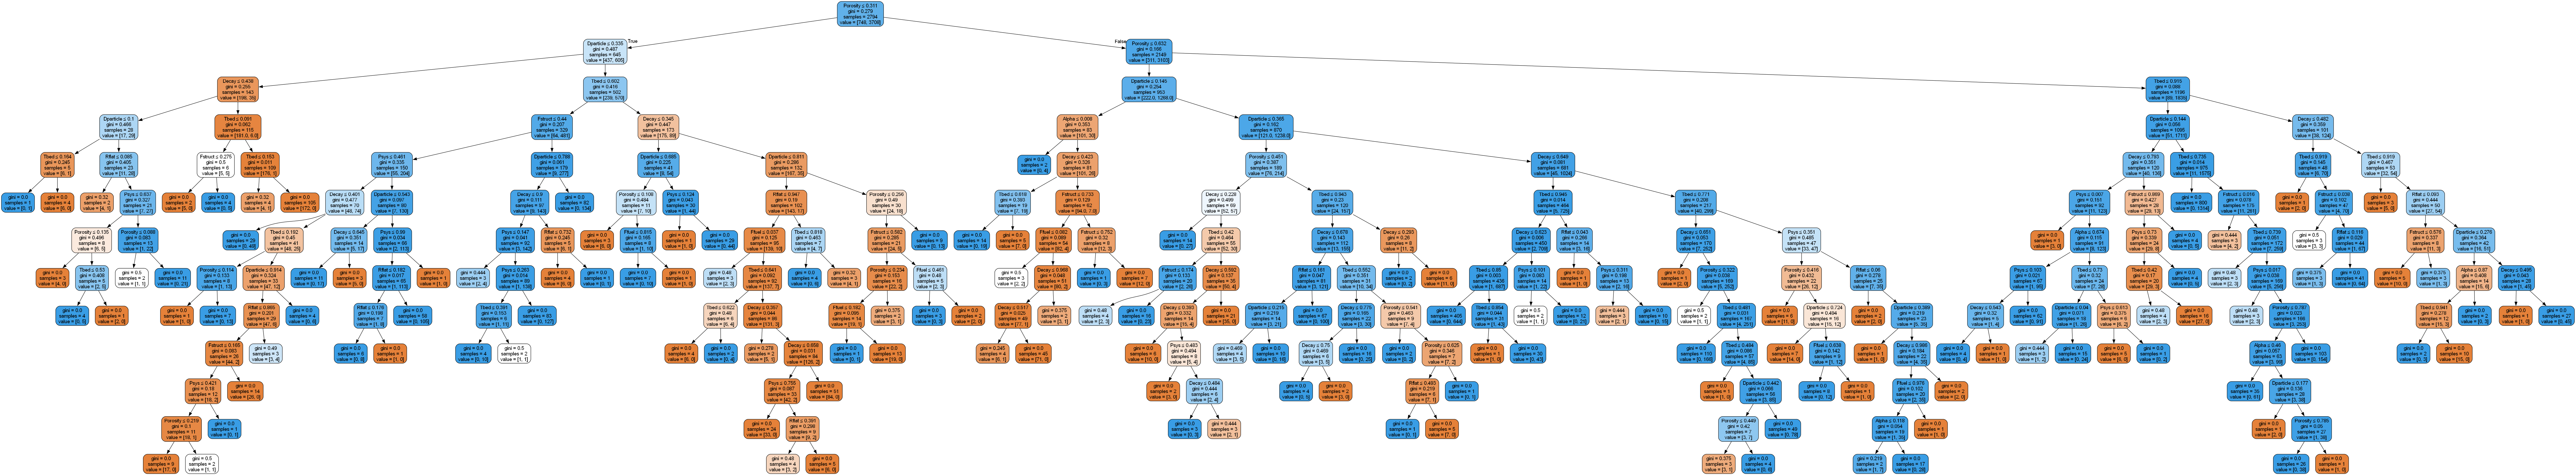

In [103]:
# print the tree for the random forest
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

from sklearn.tree import export_text
# Print the tree
for i, tree in enumerate(best_rf.estimators_):
    print(f"Tree {i}:\n")
    print(export_text(tree, feature_names=list(X.columns)))
    print("\n" + "="*50 + "\n")
    
# print tree as png
from sklearn.tree import export_graphviz
import graphviz
# Export as dot file
dot_file = export_graphviz(best_rf.estimators_[0], out_file=None, 
                             feature_names=X.columns,  
                             filled=True, rounded=True,  
                             special_characters=True)
# Render the dot file to a png
graph = graphviz.Source(dot_file)
graph.render("tree", format='png', cleanup=True)
print(export_text(tree, feature_names=list(X.columns), spacing=3, max_depth=3))
from IPython.display import Image
graph.render("tree", format='png', cleanup=False)
Image(filename='tree.png')

